In [1]:
!pip install pycuda mrcfile pandas numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 11.8 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp312-cp312-linux_x86_64.whl size=659050 sha256=e3630d727952cb831e80162956ab19458ecbb115859acf1c37d5536a0b9d37fd
  Stored in directory: /root/.cache/pip/wheels/d5/36/f3/ac5f09d768cad3fa15d5a3449bdfe65c3de58e69d036c73228
Successfully built pycuda


Tomogram size is (256, 256, 256)
Number of particles is 50
The box size is 32
The particle_radius=8
[[-0.06647322  0.08503049 -0.02058836 ...  0.11941969 -0.05721296
   0.13625   ]
 [-0.06282305 -0.11390717 -0.08486824 ...  0.29247826 -0.19569682
   0.01704958]
 [ 0.08512779  0.07874341  0.10838411 ...  0.05830947  0.034361
  -0.07553269]
 ...
 [ 0.00580962  0.01894193  0.02770112 ...  0.23500203 -0.03773128
   0.11636342]
 [-0.06149146  0.02553561  0.05332678 ...  0.06901505 -0.07616162
  -0.00189351]
 [ 0.0621837   0.04472126  0.08918939 ...  0.10588056 -0.24316159
   0.1941471 ]]
Generated 50 particles in tomogram


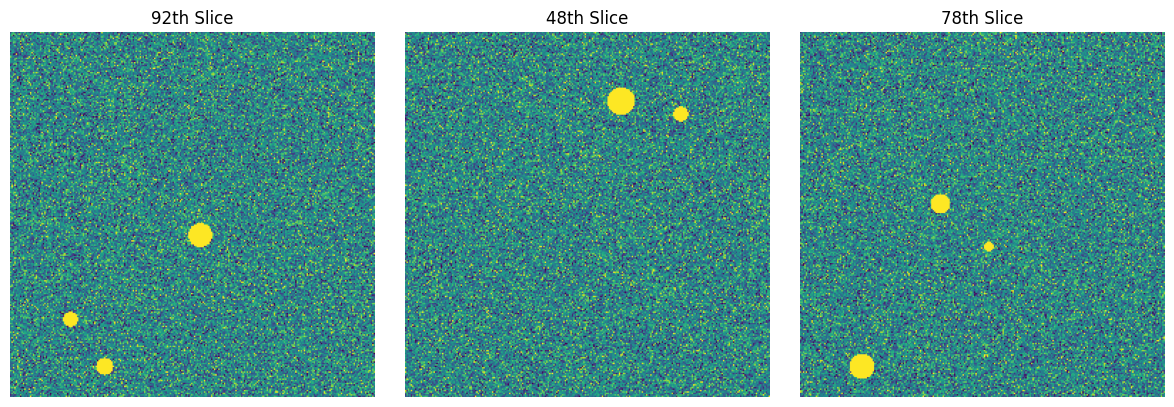

In [2]:
import numpy as np
#import pycuda.driver as cuda
#import pycuda.autoinit
#from pycuda.complier import SourceModule
#import pycuda.gpuarray as gpuarray
import mrcfile
import pandas as pd
import time

# Generating Synthetic Data

# generate_synthetic_data: Tuple, Int, Int, Int) -> mrc and star file
# generates synthetic tomograms with 3D volumes
# A mrc and star file, where an mrc is the 3D image volume
# star is the text file containing metadata and coordinates of the mrc file

def generate_synthetic_data(tomogram_size,
                            num_particles,
                            box_size,
                            particle_radius):

  print(f"Tomogram size is {tomogram_size}")
  print(f"Number of particles is {num_particles}")
  print(f"The box size is {box_size}")
  print(f"The particle_radius=8")

  tomogram = np.random.randn(*tomogram_size).astype(np.float32) * 0.1
  print(tomogram[0])

  # particle coordinates
  margin = box_size // 2 + 5
  coordinates = []

  for i in range(num_particles):
    x = np.random.randint(margin, tomogram_size[2] - margin)
    y = np.random.randint(margin, tomogram_size[1] - margin)
    z = np.random.randint(margin, tomogram_size[0] - margin)
    coordinates.append([x, y, z])

    intensity = np.random.uniform(0.8, 1.2)
    actual_radius = particle_radius + np.random.randint(-2, 3)

    for dz in range(-actual_radius, actual_radius + 1):
      for dy in range(-actual_radius, actual_radius + 1):
        for dx in range(-actual_radius, actual_radius + 1):
          if dx**2 + dy**2 + dz**2 <= actual_radius**2:

            #eq to print sphere
            if 0 <= z+dz < tomogram_size[0] and 0 <= y+dy < tomogram_size[1] and 0 <= x+dx < tomogram_size[2]:
              tomogram[z+dz, y+dy, x+dx] += intensity

  #mrc
  with mrcfile.new('synth_tomo.mrc', overwrite=True) as mrc:
    mrc.set_data(tomogram)
  #star
  star_data = pd.DataFrame({
      'rlnCoordinateX': [c[0] for c in coordinates],
      'rlnCoordinateY': [c[1] for c in coordinates],
      'rlnCoordinateZ': [c[2] for c in coordinates]
  })

  with open('particles.star', 'w') as f:
    f.write("\ndata_\n\nloop_\n")
    f.write("_rlnCoordinateX #1\n")
    f.write("_rlnCoordinateY #2\n")
    f.write("_rlnCoordinateZ #3\n")
    for _, row in star_data.iterrows():
      f.write(f"{row['rlnCoordinateX']:.6f} {row['rlnCoordinateY']:.6f} {row['rlnCoordinateZ']:.6f}\n")

  print(f"Generated {num_particles} particles in tomogram")
  return tomogram, np.array(coordinates)

tomogram, coordinates = generate_synthetic_data((256, 256, 256),
                                                50,
                                                32,
                                                8)

import matplotlib.pyplot as plt

Z, Y, X = tomogram.shape
i = np.random.choice(Z, size=3, replace=False)
vmin, vmax = np.percentile(tomogram, [1, 99])

plt.figure(figsize=(12, 4))
for i, z in enumerate(i, 1):
  plt.subplot(1, 3, i)
  plt.imshow(tomogram[z], origin='lower', vmin=vmin, vmax=vmax)
  plt.title(str(z) + "th Slice")
  plt.axis('off')

plt.tight_layout()
plt.show()




In [3]:
def load_real_data():
    with mrcfile.open('synth_tomo.mrc') as mrc:
        tomogram = mrc.data.astype(np.float32)
    coords_list = []
    with open('particles.star', 'r') as f:
        lines = f.readlines()
        reading_data = False
        for line in lines:
            if line.strip() and not line.startswith('_') and not line.startswith('loop') and not line.startswith('data'):
                if reading_data:
                    parts = line.split()
                    if len(parts) >= 3:
                        coords_list.append([float(parts[0]), float(parts[1]), float(parts[2])])
            if '_rlnCoordinateZ' in line:
                reading_data = True

    coordinates = np.array(coords_list, dtype=np.int32)
    return tomogram, coordinates


extract subtomograms from the large tomogram at the specified particle locations (star file) to average

In [ ]:
import time
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray

extraction_kernel_code = """
__global__ void extract_subtomograms(
    float* tomogram,
    float* subtomograms,
    int* coordinates,
    int num_particles,
    int tomo_z, int tomo_y, int tomo_x,
    int box_size)
{
    int global_idx = blockIdx.x * blockDim.x + threadIdx.x;
    int total_voxels_per_particle = box_size * box_size * box_size;
    int total_voxels = num_particles * total_voxels_per_particle;

    if (global_idx >= total_voxels) return;

    int particle_idx = global_idx / total_voxels_per_particle;
    int voxel_idx = global_idx % total_voxels_per_particle;

    int local_x = voxel_idx % box_size;
    int local_y = (voxel_idx / box_size) % box_size;
    int local_z = voxel_idx / (box_size * box_size);

    int center_x = coordinates[particle_idx * 3 + 0];
    int center_y = coordinates[particle_idx * 3 + 1];
    int center_z = coordinates[particle_idx * 3 + 2];

    int half_box = box_size / 2;
    int src_x = center_x - half_box + local_x;
    int src_y = center_y - half_box + local_y;
    int src_z = center_z - half_box + local_z;

    if (src_x < 0 || src_x >= tomo_x ||
        src_y < 0 || src_y >= tomo_y ||
        src_z < 0 || src_z >= tomo_z) {
        subtomograms[global_idx] = 0.0f;
    } else {
        int src_idx = src_z * tomo_y * tomo_x + src_y * tomo_x + src_x;
        subtomograms[global_idx] = tomogram[src_idx];
    }
}
"""

In [ ]:
averaging_kernel_code = """
__global__ void average_subtomograms(
    float* subtomograms,
    float* average,
    int num_particles,
    int box_size)
{
    int global_idx = blockIdx.x * blockDim.x + threadIdx.x;
    int total_voxels = box_size * box_size * box_size;

    if (global_idx >= total_voxels) return;

    float sum = 0.0f;
    for (int p = 0; p < num_particles; p++) {
        int src_idx = p * total_voxels + global_idx;
        sum += subtomograms[src_idx];
    }

    average[global_idx] = sum / (float)num_particles;
}
"""

In [9]:
def process_subtomogram_averaging(tomogram, coordinates, box_size):
    num_particles = len(coordinates)
    tomo_shape = tomogram.shape

    extraction_mod = SourceModule(extraction_kernel_code)
    extract_kernel = extraction_mod.get_function("extract_subtomograms")

    averaging_mod = SourceModule(averaging_kernel_code)
    average_kernel = averaging_mod.get_function("average_subtomograms")

    tomogram_gpu = gpuarray.to_gpu(tomogram.astype(np.float32))
    coordinates_gpu = gpuarray.to_gpu(coordinates.astype(np.int32).ravel())

    subtomograms_shape = num_particles * box_size * box_size * box_size
    subtomograms_gpu = gpuarray.zeros(subtomograms_shape, dtype=np.float32)

    total_voxels = subtomograms_shape
    threads_per_block = 256
    blocks_per_grid = (total_voxels + threads_per_block - 1) // threads_per_block

    extract_kernel(
        tomogram_gpu,
        subtomograms_gpu,
        coordinates_gpu,
        np.int32(num_particles),
        np.int32(tomo_shape[0]),
        np.int32(tomo_shape[1]),
        np.int32(tomo_shape[2]),
        np.int32(box_size),
        block=(threads_per_block, 1, 1),
        grid=(blocks_per_grid, 1, 1)
    )

    cuda.Context.synchronize()

    average_gpu = gpuarray.zeros(box_size * box_size * box_size, dtype=np.float32)

    total_voxels = box_size * box_size * box_size
    threads_per_block = 256
    blocks_per_grid = (total_voxels + threads_per_block - 1) // threads_per_block

    average_kernel(
        subtomograms_gpu,
        average_gpu,
        np.int32(num_particles),
        np.int32(box_size),
        block=(threads_per_block, 1, 1),
        grid=(blocks_per_grid, 1, 1)
    )

    cuda.Context.synchronize()

    average_cpu = average_gpu.get().reshape((box_size, box_size, box_size))
    print("done")
    return average_cpu


In [12]:
box_size = 32
average_volume = process_subtomogram_averaging(tomogram, coordinates, box_size)

with mrcfile.new('average.mrc', overwrite=True) as mrc:
    mrc.set_data(average_volume.astype(np.float32))



done


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display

def create_animated_slices(volume, axis=0, interval=50, cmap='gray'):
    fig, ax = plt.subplots(figsize=(8, 8))

    if axis == 0:
        im = ax.imshow(volume[0, :, :], cmap=cmap, animated=True)
        num_frames = volume.shape[0]
        title_base = 'Z slice: '
    elif axis == 1:
        im = ax.imshow(volume[:, 0, :], cmap=cmap, animated=True)
        num_frames = volume.shape[1]
        title_base = 'Y slice: '
    else:
        im = ax.imshow(volume[:, :, 0], cmap=cmap, animated=True)
        num_frames = volume.shape[2]
        title_base = 'X slice: '

    plt.colorbar(im)

    def update(frame):
        if axis == 0:
            im.set_data(volume[frame, :, :])
        elif axis == 1:
            im.set_data(volume[:, frame, :])
        else:
            im.set_data(volume[:, :, frame])
        ax.set_title(f'{title_base}{frame}')
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=num_frames,
                                 interval=interval, blit=True, repeat=True)
    plt.close()
    return HTML(ani.to_jshtml())


print("Animated slices through Z-axis:")
ani_html = create_animated_slices(average_volume, axis=0, interval=100)
display(ani_html)





[5] Animated slices through Z-axis:
